# First-Order Optimization Methods for Regression Modeling

The code below leverages the Boston Housing dataset to demonstrate the behavior of various first order optimization methods when applied to a simple NN with two linear layers.

In [28]:
# Load all required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from pandas import read_csv
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt
import os
import time

%matplotlib notebook
warnings.filterwarnings('ignore')


Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.  

In [2]:
# Load data
# Data source : https://archive.ics.uci.edu/ml/machine-learning-databases/housing/
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('/housing.data', header=None, delimiter=r"\s+", names=column_names)
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [3]:
# obtain various data stats
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

In [4]:
# check for null values in data
print(np.sum(np.isnan(data)))

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


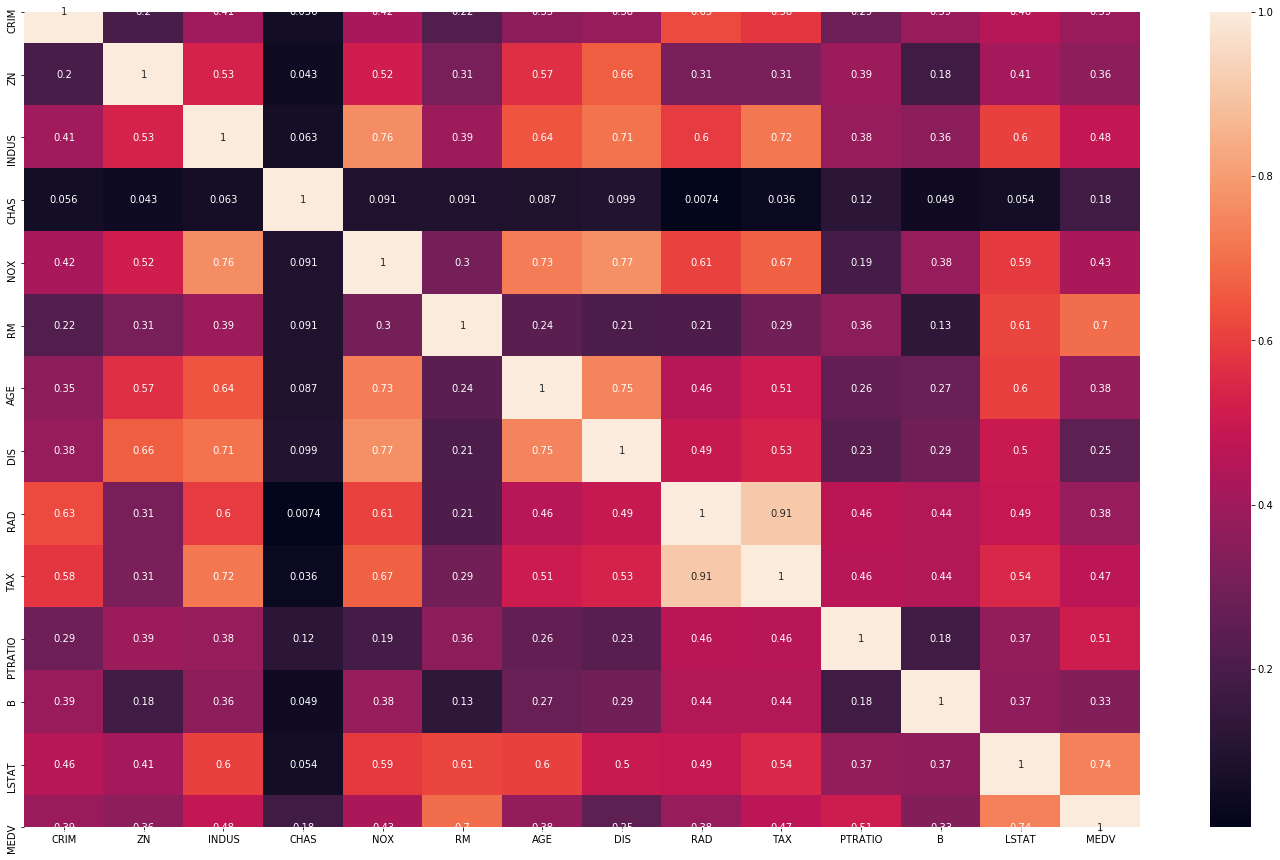

In [5]:
# obtain correlation plot
plt.figure(figsize=(25, 15))
sns.heatmap(data.corr().abs(), annot=True)

We observe that LSTAT,RM have a correlation score >= 0.7 with MEDV which indicates that they could serve as good predictors of the the MEDV value. 

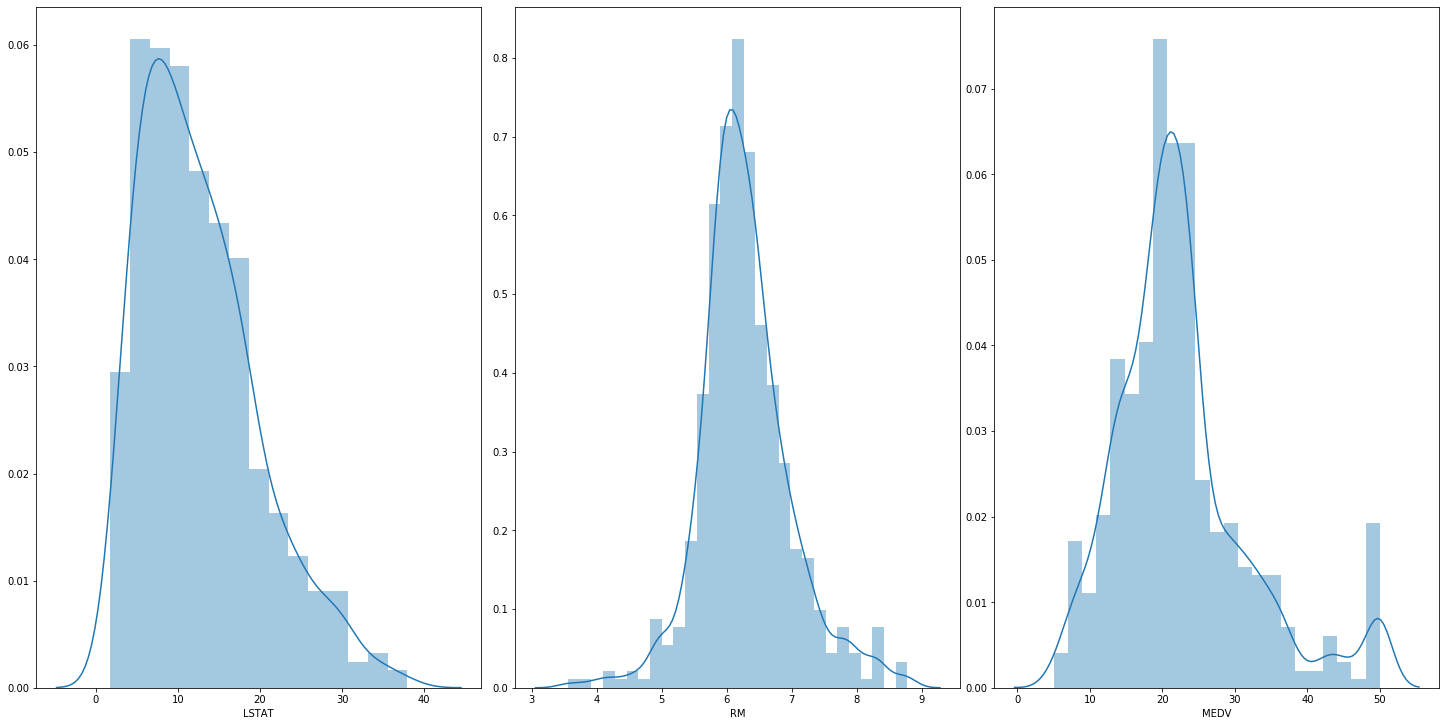

In [6]:
# plot the distribution of the feature and target values
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
sns.distplot(data['LSTAT'],ax=axs[0])
sns.distplot(data['RM'],ax=axs[1])
sns.distplot(data['MEDV'],ax=axs[2])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [7]:
# Set feature and target values
y = data['MEDV'].copy()
X = data[['RM', 'LSTAT']].copy()


In [8]:
X = X.to_numpy().reshape(len(X),2)


In [9]:
# custom class to normalize input data and labels
class CustomDataset(Data.Dataset):
    def __init__(self, X, y):         
        scaler = MinMaxScaler()
        self.targets = scaler.fit_transform(X.astype(np.float32))
        self.labels = y.astype(np.float32)
    
    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]

    def __len__(self):
        return len(self.targets)

In [10]:
tf_X_train, tf_X_test, tf_y_train, tf_y_test = train_test_split(X, y, random_state=1)


In [11]:
#obtain the final train and test sets
train_set = CustomDataset(tf_X_train, tf_y_train.to_numpy())
test_set = CustomDataset(tf_X_test, tf_y_test.to_numpy())

In [12]:
n_samples, n_features = tf_X_train.shape

In [13]:
#total number of examples in training data
n_samples

379

In [14]:
# total number of features
n_features

2

In [15]:
# Simple 2 linear layer NN
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenB)       
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))        
        return self.linearC(yA)

In [16]:
# function to train model
# Accepts batch size, number of epochs, training set, loss criterion, optimizer, and the model
def train_model(bs, n_epochs,train_set,criterion,optimizer,net):
    start = time.time()    
    train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
    n_epochs = 200
    all_losses = []
    for epoch in range(n_epochs):
        progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
        losses = []
        total = 0
        for inputs, target in progress_bar:
            optimizer.zero_grad()
            y_pred = net(inputs) # make prediction given inputs
            loss = criterion(y_pred, torch.unsqueeze(target,dim=1)) # compute loss
            loss.backward()
            optimizer.step()
            progress_bar.set_description(f'Loss: {loss.item():.3f}')
            losses.append(loss.item())
            total += 1

        epoch_loss = sum(losses) / total
        all_losses.append(epoch_loss) #append the loss

        mess = f"Epoch #{epoch}\tLoss: {all_losses[-1]:.3f}"
        tqdm.tqdm.write(mess)
        
    end = time.time()
    t = (end - start)
    print("Time taken:" + str(t) + " seconds. ") #print time taken
    return (all_losses,t,all_losses[-1])

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #0	Loss: 216565.797


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #1	Loss: 49631.512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #2	Loss: 171235.344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #3	Loss: 206290.828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #4	Loss: 180570.359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #5	Loss: 158607.688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #6	Loss: 139849.109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #7	Loss: 123822.133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #8	Loss: 110113.828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #9	Loss: 98334.055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #10	Loss: 87982.930


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #11	Loss: 77963.422


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #12	Loss: 65427.574


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #13	Loss: 45871.164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #14	Loss: 28414.617


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #15	Loss: 27084.912


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #16	Loss: 25977.854


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #17	Loss: 24847.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #18	Loss: 23738.061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #19	Loss: 22596.629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #20	Loss: 21446.115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #21	Loss: 20276.594


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #22	Loss: 19129.941


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #23	Loss: 18000.006


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #24	Loss: 16942.471


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #25	Loss: 15955.001


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #26	Loss: 15133.888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #27	Loss: 14482.201


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #28	Loss: 14451.890


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #29	Loss: 15766.425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #30	Loss: 22725.631


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #31	Loss: 30672.645


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #32	Loss: 56653.840


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #33	Loss: 19640.635


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #34	Loss: 16918.084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #35	Loss: 21844.232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #36	Loss: 16883.016


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #37	Loss: 22406.682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #38	Loss: 16121.758


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #39	Loss: 20930.760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #40	Loss: 15501.705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #41	Loss: 19807.473


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #42	Loss: 15015.594


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #43	Loss: 18807.129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #44	Loss: 14607.840


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #45	Loss: 18203.816


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #46	Loss: 14285.938


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #47	Loss: 17845.814


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #48	Loss: 13898.449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #49	Loss: 17106.002


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #50	Loss: 13622.085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #51	Loss: 16612.984


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #52	Loss: 13251.992


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #53	Loss: 15858.908


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #54	Loss: 12952.317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #55	Loss: 15330.801


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #56	Loss: 12741.579


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #57	Loss: 14996.800


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #58	Loss: 12529.026


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #59	Loss: 14743.452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #60	Loss: 12394.547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #61	Loss: 14478.498


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #62	Loss: 12095.977


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #63	Loss: 13926.135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #64	Loss: 11868.188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #65	Loss: 13534.213


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #66	Loss: 11631.929


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #67	Loss: 12966.028


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #68	Loss: 11425.115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #69	Loss: 12625.112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #70	Loss: 11272.581


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #71	Loss: 12425.073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #72	Loss: 11197.533


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #73	Loss: 12309.624


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #74	Loss: 11030.496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #75	Loss: 12134.372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #76	Loss: 10887.407


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #77	Loss: 11869.760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #78	Loss: 10641.695


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #79	Loss: 11424.775


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #80	Loss: 10462.443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #81	Loss: 11156.440


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #82	Loss: 10359.332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #83	Loss: 11021.687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #84	Loss: 10313.037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #85	Loss: 10990.084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #86	Loss: 10353.651


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #87	Loss: 11063.702


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #88	Loss: 10379.996


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #89	Loss: 11127.473


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #90	Loss: 10417.181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #91	Loss: 11155.777


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #92	Loss: 10432.488


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #93	Loss: 11153.208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #94	Loss: 10429.477


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #95	Loss: 11143.624


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #96	Loss: 10419.670


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #97	Loss: 11110.305


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #98	Loss: 10388.720


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #99	Loss: 11127.116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #100	Loss: 10394.966


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #101	Loss: 11043.782


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #102	Loss: 10336.324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #103	Loss: 10952.662


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #104	Loss: 10276.138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #105	Loss: 10856.811


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #106	Loss: 10203.333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #107	Loss: 10822.632


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #108	Loss: 10161.912


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #109	Loss: 10730.653


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #110	Loss: 10096.293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #111	Loss: 10646.424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #112	Loss: 10041.586


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #113	Loss: 10600.906


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #114	Loss: 10016.575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #115	Loss: 10482.729


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #116	Loss: 9950.268


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #117	Loss: 10389.757


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #118	Loss: 9896.803


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #119	Loss: 10410.585


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #120	Loss: 9852.385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #121	Loss: 10369.716


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #122	Loss: 9808.810


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #123	Loss: 10319.476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #124	Loss: 9771.869


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #125	Loss: 10230.466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #126	Loss: 9724.199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #127	Loss: 10179.051


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #128	Loss: 9677.818


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #129	Loss: 10114.354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #130	Loss: 9641.195


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #131	Loss: 10073.927


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #132	Loss: 9617.686


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #133	Loss: 10027.504


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #134	Loss: 9588.654


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #135	Loss: 10007.214


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #136	Loss: 9575.377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #137	Loss: 10000.208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #138	Loss: 9563.707


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #139	Loss: 9986.967


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #140	Loss: 9553.282


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #141	Loss: 9980.046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #142	Loss: 9542.160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #143	Loss: 9973.036


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #144	Loss: 9513.207


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #145	Loss: 9942.683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #146	Loss: 9492.312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #147	Loss: 9922.569


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #148	Loss: 9474.283


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #149	Loss: 9889.695


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #150	Loss: 9439.911


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #151	Loss: 9840.043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #152	Loss: 9407.606


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #153	Loss: 9801.766


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #154	Loss: 9372.913


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #155	Loss: 9760.828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #156	Loss: 9345.610


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #157	Loss: 9716.476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #158	Loss: 9316.785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #159	Loss: 9682.400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #160	Loss: 9293.800


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #161	Loss: 9653.057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #162	Loss: 9273.738


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #163	Loss: 9631.092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #164	Loss: 9257.906


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #165	Loss: 9600.880


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #166	Loss: 9237.124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #167	Loss: 9577.068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #168	Loss: 9220.041


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #169	Loss: 9539.715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #170	Loss: 9194.316


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #171	Loss: 9509.642


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #172	Loss: 9172.853


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #173	Loss: 9469.718


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #174	Loss: 9144.766


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #175	Loss: 9434.107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #176	Loss: 9103.385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #177	Loss: 9394.578


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #178	Loss: 9076.622


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #179	Loss: 9361.229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #180	Loss: 9079.652


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #181	Loss: 9357.364


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #182	Loss: 9074.563


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #183	Loss: 9330.320


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #184	Loss: 9054.093


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #185	Loss: 9304.064


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #186	Loss: 9062.570


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #187	Loss: 9307.713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #188	Loss: 9068.568


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #189	Loss: 9326.562


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #190	Loss: 9077.218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #191	Loss: 9337.030


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #192	Loss: 9080.613


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #193	Loss: 9342.164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #194	Loss: 9080.332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #195	Loss: 9343.102


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #196	Loss: 9077.675


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #197	Loss: 9340.443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #198	Loss: 9062.143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #199	Loss: 9320.157
Time taken:6.838547229766846 seconds. 


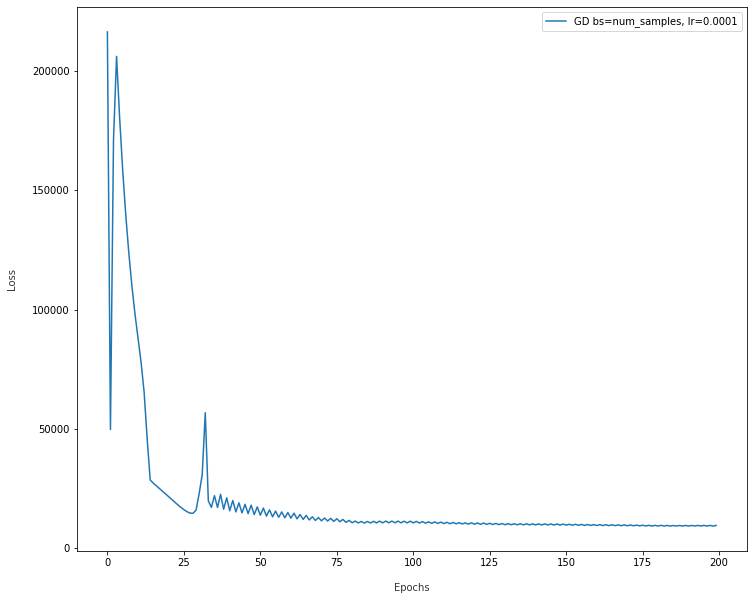

In [17]:
# GD
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_gd = Model(n_features, 100, 50)
optimizer = optim.SGD(net_gd.parameters(), lr=0.0001)
# for batch gradient descent the batch size = full dataset = # of samples
all_losses_gd,t_gd,l_gd = train_model(n_samples, 200,train_set,criterion,optimizer,net_gd)


plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_gd)), all_losses_gd, label = 'GD bs=num_samples, lr=0.0001')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #0	Loss: 79.215


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #1	Loss: 46.886


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #2	Loss: 36.183


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #3	Loss: 35.167


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #4	Loss: 33.404


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #5	Loss: 33.722


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #6	Loss: 34.709


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #7	Loss: 34.479


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #8	Loss: 38.551


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #9	Loss: 33.797


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #10	Loss: 31.464


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #11	Loss: 33.531


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #12	Loss: 43.041


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #13	Loss: 46.709


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #14	Loss: 45.791


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #15	Loss: 46.666


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #16	Loss: 51.948


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #17	Loss: 47.743


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #18	Loss: 45.167


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #19	Loss: 48.091


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #20	Loss: 45.095


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #21	Loss: 47.078


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #22	Loss: 49.728


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #23	Loss: 46.934


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #24	Loss: 45.230


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #25	Loss: 46.152


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #26	Loss: 47.141


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #27	Loss: 49.355


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #28	Loss: 43.199


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #29	Loss: 43.645


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #30	Loss: 47.708


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #31	Loss: 45.602


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #32	Loss: 46.304


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #33	Loss: 47.575


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #34	Loss: 48.976


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #35	Loss: 45.870


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #36	Loss: 50.456


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #37	Loss: 45.182


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #38	Loss: 45.823


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #39	Loss: 47.251


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #40	Loss: 47.569


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #41	Loss: 50.523


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #42	Loss: 48.059


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #43	Loss: 44.907


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #44	Loss: 42.801


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #45	Loss: 46.134


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #46	Loss: 46.075


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #47	Loss: 45.687


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #48	Loss: 46.498


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #49	Loss: 46.731


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #50	Loss: 45.435


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #51	Loss: 47.003


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #52	Loss: 45.667


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #53	Loss: 43.652


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #54	Loss: 42.919


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #55	Loss: 41.337


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #56	Loss: 43.494


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #57	Loss: 60.162


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #58	Loss: 43.354


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #59	Loss: 43.935


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #60	Loss: 45.054


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #61	Loss: 45.188


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #62	Loss: 47.754


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #63	Loss: 47.572


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #64	Loss: 45.748


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #65	Loss: 70.875


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #66	Loss: 80.678


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #67	Loss: 80.206


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #68	Loss: 79.761


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #69	Loss: 79.723


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #70	Loss: 79.797


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #71	Loss: 47.469


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #72	Loss: 48.138


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #73	Loss: 45.287


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #74	Loss: 42.888


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #75	Loss: 45.714


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #76	Loss: 51.577


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #77	Loss: 83.444


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #78	Loss: 79.735


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #79	Loss: 62.340


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #80	Loss: 46.279


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #81	Loss: 48.130


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #82	Loss: 42.534


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #83	Loss: 43.510


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #84	Loss: 44.168


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #85	Loss: 49.897


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #86	Loss: 43.534


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #87	Loss: 43.794


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #88	Loss: 53.057


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #89	Loss: 42.252


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #90	Loss: 49.594


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #91	Loss: 43.068


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #92	Loss: 42.972


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #93	Loss: 40.952


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #94	Loss: 49.835


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #95	Loss: 48.132


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #96	Loss: 43.511


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #97	Loss: 42.080


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #98	Loss: 54.737


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #99	Loss: 43.095


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #100	Loss: 43.078


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #101	Loss: 41.716


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #102	Loss: 43.456


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #103	Loss: 44.531


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #104	Loss: 43.418


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #105	Loss: 47.526


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #106	Loss: 42.995


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #107	Loss: 46.886


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #108	Loss: 46.294


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #109	Loss: 47.106


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #110	Loss: 60.785


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #111	Loss: 80.640


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #112	Loss: 79.821


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #113	Loss: 72.740


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #114	Loss: 49.806


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #115	Loss: 43.881


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #116	Loss: 38.714


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #117	Loss: 38.535


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #118	Loss: 35.610


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #119	Loss: 83.194


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #120	Loss: 80.446


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #121	Loss: 80.539


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #122	Loss: 78.046


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #123	Loss: 50.111


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #124	Loss: 46.224


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #125	Loss: 44.338


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #126	Loss: 46.875


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #127	Loss: 52.935


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #128	Loss: 45.938


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #129	Loss: 46.321


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #130	Loss: 47.633


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #131	Loss: 44.918


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #132	Loss: 44.530


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #133	Loss: 49.182


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #134	Loss: 47.729


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #135	Loss: 46.752


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #136	Loss: 45.704


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #137	Loss: 45.118


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #138	Loss: 45.713


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #139	Loss: 50.943


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #140	Loss: 46.488


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #141	Loss: 44.574


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #142	Loss: 49.478


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #143	Loss: 46.877


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #144	Loss: 45.916


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #145	Loss: 42.521


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #146	Loss: 49.014


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #147	Loss: 46.703


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #148	Loss: 48.037


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #149	Loss: 48.178


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #150	Loss: 49.389


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #151	Loss: 46.506


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #152	Loss: 42.404


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #153	Loss: 44.221


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #154	Loss: 47.814


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #155	Loss: 50.057


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #156	Loss: 55.066


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #157	Loss: 50.390


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #158	Loss: 45.981


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #159	Loss: 44.811


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #160	Loss: 46.473


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #161	Loss: 44.845


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #162	Loss: 50.818


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #163	Loss: 47.805


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #164	Loss: 48.450


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #165	Loss: 46.865


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #166	Loss: 44.725


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #167	Loss: 47.912


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #168	Loss: 45.187


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #169	Loss: 45.648


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #170	Loss: 47.600


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #171	Loss: 62.302


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #172	Loss: 57.167


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #173	Loss: 45.476


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #174	Loss: 48.424


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #175	Loss: 45.275


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #176	Loss: 41.956


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #177	Loss: 45.264


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #178	Loss: 42.745


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #179	Loss: 50.113


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #180	Loss: 44.168


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #181	Loss: 48.999


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #182	Loss: 47.856


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #183	Loss: 44.699


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #184	Loss: 48.211


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #185	Loss: 51.614


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #186	Loss: 47.140


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #187	Loss: 45.344


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #188	Loss: 48.499


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #189	Loss: 49.921


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #190	Loss: 44.129


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #191	Loss: 46.695


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #192	Loss: 46.647


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #193	Loss: 45.972


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #194	Loss: 47.483


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #195	Loss: 42.983


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #196	Loss: 44.779


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #197	Loss: 45.898


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #198	Loss: 44.979


  0%|          | 0/379 [00:00<?, ?it/s]

Epoch #199	Loss: 46.023
Time taken:101.63996934890747 seconds. 


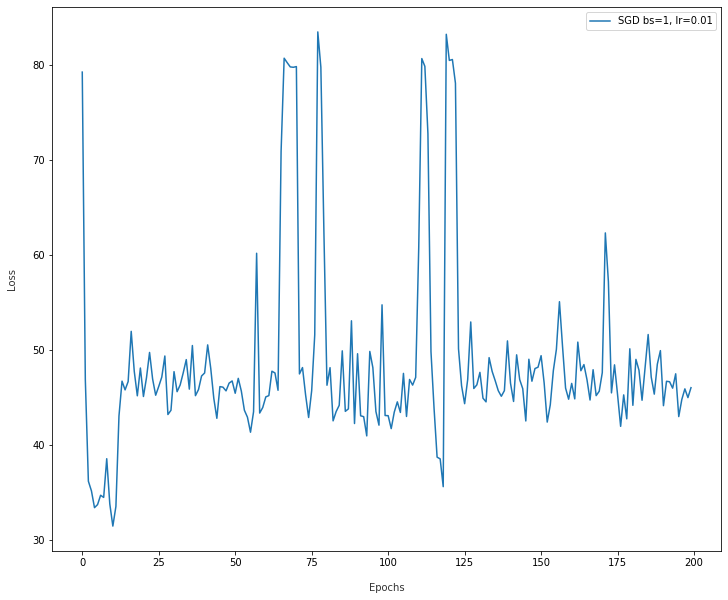

In [18]:
#SGD
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_SGD = Model(n_features, 100, 50)
optimizer = optim.SGD(net_SGD.parameters(), lr=0.01) 
# for strochastic gradient descent the batch size = 1
all_losses_sgd,t_sgd,l_sgd= train_model(1, 200,train_set,criterion,optimizer,net_SGD)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_sgd)), all_losses_sgd, label = 'SGD bs=1, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #0	Loss: 1054.530


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #1	Loss: 634.394


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #2	Loss: 637.052


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #3	Loss: 628.965


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #4	Loss: 637.376


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #5	Loss: 637.834


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #6	Loss: 631.773


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #7	Loss: 635.171


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #8	Loss: 642.532


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #9	Loss: 635.427


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #10	Loss: 632.902


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #11	Loss: 638.316


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #12	Loss: 632.526


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #13	Loss: 633.934


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #14	Loss: 626.932


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #15	Loss: 636.108


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #16	Loss: 633.748


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #17	Loss: 625.492


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #18	Loss: 630.045


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #19	Loss: 639.518


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #20	Loss: 632.537


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #21	Loss: 640.820


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #22	Loss: 632.775


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #23	Loss: 635.056


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #24	Loss: 634.071


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #25	Loss: 632.470


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #26	Loss: 630.966


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #27	Loss: 626.741


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #28	Loss: 635.672


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #29	Loss: 635.569


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #30	Loss: 638.630


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #31	Loss: 633.075


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #32	Loss: 632.156


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #33	Loss: 637.862


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #34	Loss: 637.002


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #35	Loss: 627.613


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #36	Loss: 635.990


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #37	Loss: 633.779


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #38	Loss: 627.185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #39	Loss: 633.678


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #40	Loss: 628.259


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #41	Loss: 633.866


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #42	Loss: 631.116


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #43	Loss: 640.578


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #44	Loss: 638.708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #45	Loss: 639.239


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #46	Loss: 633.219


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #47	Loss: 630.759


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #48	Loss: 632.236


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #49	Loss: 639.204


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #50	Loss: 635.001


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #51	Loss: 632.965


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #52	Loss: 629.990


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #53	Loss: 630.146


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #54	Loss: 639.413


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #55	Loss: 631.179


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #56	Loss: 632.956


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #57	Loss: 636.392


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #58	Loss: 635.945


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #59	Loss: 639.007


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #60	Loss: 631.916


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #61	Loss: 636.259


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #62	Loss: 633.197


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #63	Loss: 631.312


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #64	Loss: 630.693


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #65	Loss: 641.162


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #66	Loss: 631.326


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #67	Loss: 633.089


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #68	Loss: 637.162


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #69	Loss: 630.909


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #70	Loss: 639.366


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #71	Loss: 634.452


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #72	Loss: 632.980


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #73	Loss: 636.667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #74	Loss: 630.694


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #75	Loss: 631.877


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #76	Loss: 632.800


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #77	Loss: 635.272


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #78	Loss: 636.818


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #79	Loss: 630.516


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #80	Loss: 634.964


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #81	Loss: 634.389


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #82	Loss: 637.921


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #83	Loss: 631.680


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #84	Loss: 637.393


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #85	Loss: 634.357


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #86	Loss: 634.453


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #87	Loss: 630.847


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #88	Loss: 634.911


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #89	Loss: 636.338


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #90	Loss: 633.356


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #91	Loss: 631.680


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #92	Loss: 633.688


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #93	Loss: 634.858


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #94	Loss: 634.804


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #95	Loss: 637.402


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #96	Loss: 635.670


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #97	Loss: 635.516


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #98	Loss: 635.903


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #99	Loss: 633.563


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #100	Loss: 633.581


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #101	Loss: 632.887


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #102	Loss: 637.979


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #103	Loss: 638.571


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #104	Loss: 636.855


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #105	Loss: 640.251


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #106	Loss: 635.711


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #107	Loss: 633.842


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #108	Loss: 627.711


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #109	Loss: 631.032


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #110	Loss: 634.139


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #111	Loss: 638.894


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #112	Loss: 632.894


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #113	Loss: 635.329


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #114	Loss: 635.367


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #115	Loss: 633.209


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #116	Loss: 637.612


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #117	Loss: 640.234


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #118	Loss: 638.259


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #119	Loss: 634.329


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #120	Loss: 637.309


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #121	Loss: 638.918


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #122	Loss: 634.954


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #123	Loss: 637.756


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #124	Loss: 636.139


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #125	Loss: 630.035


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #126	Loss: 633.293


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #127	Loss: 629.537


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #128	Loss: 639.244


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #129	Loss: 633.083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #130	Loss: 641.267


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #131	Loss: 634.298


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #132	Loss: 637.030


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #133	Loss: 634.480


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #134	Loss: 633.376


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #135	Loss: 635.536


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #136	Loss: 637.602


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #137	Loss: 629.548


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #138	Loss: 631.010


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #139	Loss: 637.487


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #140	Loss: 631.578


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #141	Loss: 628.168


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #142	Loss: 638.359


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #143	Loss: 636.185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #144	Loss: 633.582


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #145	Loss: 628.412


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #146	Loss: 624.126


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #147	Loss: 642.864


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #148	Loss: 634.024


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #149	Loss: 632.836


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #150	Loss: 640.520


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #151	Loss: 627.074


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #152	Loss: 637.040


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #153	Loss: 632.008


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #154	Loss: 638.045


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #155	Loss: 636.013


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #156	Loss: 638.022


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #157	Loss: 637.919


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #158	Loss: 638.865


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #159	Loss: 635.532


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #160	Loss: 636.370


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #161	Loss: 635.641


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #162	Loss: 638.843


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #163	Loss: 635.131


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #164	Loss: 629.463


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #165	Loss: 636.838


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #166	Loss: 627.240


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #167	Loss: 639.262


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #168	Loss: 636.974


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #169	Loss: 635.982


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #170	Loss: 632.442


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #171	Loss: 638.505


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #172	Loss: 635.169


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #173	Loss: 634.795


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #174	Loss: 634.143


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #175	Loss: 635.852


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #176	Loss: 638.929


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #177	Loss: 639.225


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #178	Loss: 633.047


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #179	Loss: 632.772


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #180	Loss: 636.097


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #181	Loss: 629.867


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #182	Loss: 631.149


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #183	Loss: 638.562


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #184	Loss: 638.686


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #185	Loss: 630.033


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #186	Loss: 638.202


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #187	Loss: 632.727


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #188	Loss: 635.263


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #189	Loss: 632.998


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #190	Loss: 634.856


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #191	Loss: 639.617


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #192	Loss: 639.972


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #193	Loss: 636.888


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #194	Loss: 632.881


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #195	Loss: 633.689


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #196	Loss: 634.766


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #197	Loss: 634.348


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #198	Loss: 635.249


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #199	Loss: 638.668
Time taken:17.68541431427002 seconds. 


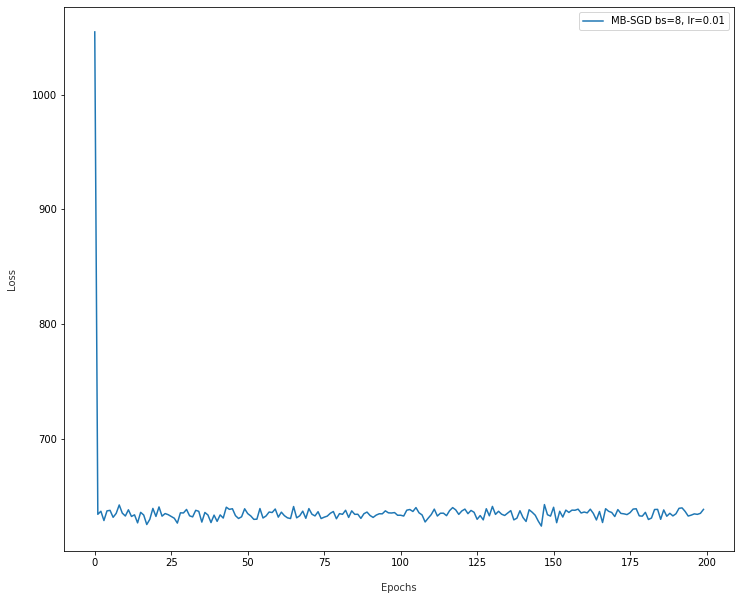

In [19]:
# MB-SGD
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_mbsgd = Model(n_features, 100, 50)
optimizer = optim.SGD(net_mbsgd.parameters(), lr=0.01)
# Setting the mini batch size to 8
all_losses_mbsgd,t_mbsgd,l_mbsgd = train_model(8, 200,train_set,criterion,optimizer,net_mbsgd)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_mbsgd)), all_losses_mbsgd, label = 'MB-SGD bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #0	Loss: 1209.491


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #1	Loss: 636.570


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #2	Loss: 699.280


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #3	Loss: 664.074


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #4	Loss: 745.001


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #5	Loss: 709.569


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #6	Loss: 788.329


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #7	Loss: 722.656


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #8	Loss: 681.184


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #9	Loss: 670.499


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #10	Loss: 673.830


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #11	Loss: 705.529


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #12	Loss: 683.042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #13	Loss: 664.170


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #14	Loss: 655.080


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #15	Loss: 686.823


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #16	Loss: 683.484


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #17	Loss: 678.551


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #18	Loss: 679.628


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #19	Loss: 674.407


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #20	Loss: 675.263


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #21	Loss: 836.071


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #22	Loss: 701.873


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #23	Loss: 760.597


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #24	Loss: 731.975


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #25	Loss: 692.608


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #26	Loss: 654.054


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #27	Loss: 642.503


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #28	Loss: 718.461


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #29	Loss: 773.895


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #30	Loss: 653.885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #31	Loss: 680.314


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #32	Loss: 675.929


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #33	Loss: 740.884


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #34	Loss: 693.081


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #35	Loss: 691.962


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #36	Loss: 720.429


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #37	Loss: 699.733


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #38	Loss: 647.268


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #39	Loss: 646.571


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #40	Loss: 647.285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #41	Loss: 677.031


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #42	Loss: 672.572


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #43	Loss: 732.447


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #44	Loss: 656.334


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #45	Loss: 734.266


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #46	Loss: 692.070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #47	Loss: 680.596


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #48	Loss: 706.436


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #49	Loss: 709.317


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #50	Loss: 681.900


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #51	Loss: 687.187


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #52	Loss: 683.091


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #53	Loss: 718.743


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #54	Loss: 668.133


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #55	Loss: 644.676


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #56	Loss: 704.439


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #57	Loss: 712.422


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #58	Loss: 718.945


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #59	Loss: 718.744


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #60	Loss: 671.987


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #61	Loss: 770.735


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #62	Loss: 733.319


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #63	Loss: 673.710


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #64	Loss: 710.887


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #65	Loss: 690.129


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #66	Loss: 650.004


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #67	Loss: 667.584


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #68	Loss: 716.611


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #69	Loss: 714.805


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #70	Loss: 708.981


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #71	Loss: 669.680


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #72	Loss: 714.928


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #73	Loss: 683.321


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #74	Loss: 675.185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #75	Loss: 691.970


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #76	Loss: 694.412


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #77	Loss: 658.782


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #78	Loss: 749.656


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #79	Loss: 819.552


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #80	Loss: 757.605


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #81	Loss: 686.900


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #82	Loss: 708.227


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #83	Loss: 650.580


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #84	Loss: 710.957


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #85	Loss: 701.984


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #86	Loss: 690.743


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #87	Loss: 681.375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #88	Loss: 659.737


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #89	Loss: 673.775


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #90	Loss: 681.441


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #91	Loss: 694.085


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #92	Loss: 699.725


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #93	Loss: 664.304


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #94	Loss: 680.480


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #95	Loss: 640.403


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #96	Loss: 682.359


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #97	Loss: 693.150


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #98	Loss: 691.177


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #99	Loss: 684.067


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #100	Loss: 665.082


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #101	Loss: 740.007


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #102	Loss: 755.879


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #103	Loss: 671.303


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #104	Loss: 665.956


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #105	Loss: 664.155


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #106	Loss: 647.470


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #107	Loss: 669.256


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #108	Loss: 689.868


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #109	Loss: 785.767


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #110	Loss: 647.637


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #111	Loss: 696.774


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #112	Loss: 671.093


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #113	Loss: 701.860


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #114	Loss: 660.102


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #115	Loss: 678.094


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #116	Loss: 657.183


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #117	Loss: 681.889


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #118	Loss: 652.524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #119	Loss: 670.385


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #120	Loss: 668.273


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #121	Loss: 675.284


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #122	Loss: 677.828


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #123	Loss: 665.309


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #124	Loss: 759.415


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #125	Loss: 690.448


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #126	Loss: 656.307


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #127	Loss: 701.071


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #128	Loss: 675.361


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #129	Loss: 654.406


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #130	Loss: 672.445


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #131	Loss: 702.286


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #132	Loss: 732.967


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #133	Loss: 705.683


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #134	Loss: 694.406


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #135	Loss: 691.179


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #136	Loss: 690.339


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #137	Loss: 667.847


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #138	Loss: 671.427


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #139	Loss: 647.772


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #140	Loss: 694.168


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #141	Loss: 661.498


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #142	Loss: 785.563


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #143	Loss: 779.932


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #144	Loss: 661.767


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #145	Loss: 693.712


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #146	Loss: 673.379


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #147	Loss: 687.110


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #148	Loss: 707.173


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #149	Loss: 682.610


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #150	Loss: 727.829


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #151	Loss: 675.491


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #152	Loss: 699.141


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #153	Loss: 629.582


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #154	Loss: 640.746


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #155	Loss: 687.719


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #156	Loss: 669.786


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #157	Loss: 719.346


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #158	Loss: 693.642


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #159	Loss: 760.544


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #160	Loss: 736.458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #161	Loss: 689.828


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #162	Loss: 679.645


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #163	Loss: 647.092


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #164	Loss: 675.822


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #165	Loss: 744.817


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #166	Loss: 675.557


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #167	Loss: 820.941


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #168	Loss: 660.987


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #169	Loss: 795.085


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #170	Loss: 647.827


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #171	Loss: 672.905


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #172	Loss: 674.294


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #173	Loss: 737.782


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #174	Loss: 683.086


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #175	Loss: 748.379


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #176	Loss: 696.117


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #177	Loss: 675.653


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #178	Loss: 714.672


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #179	Loss: 653.264


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #180	Loss: 684.753


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #181	Loss: 672.115


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #182	Loss: 643.050


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #183	Loss: 663.883


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #184	Loss: 681.835


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #185	Loss: 656.914


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #186	Loss: 672.357


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #187	Loss: 685.114


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #188	Loss: 664.515


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #189	Loss: 712.880


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #190	Loss: 669.368


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #191	Loss: 687.127


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #192	Loss: 691.115


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #193	Loss: 685.482


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #194	Loss: 660.643


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #195	Loss: 717.874


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #196	Loss: 690.998


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #197	Loss: 721.157


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #198	Loss: 724.598


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #199	Loss: 663.639
Time taken:18.010265111923218 seconds. 


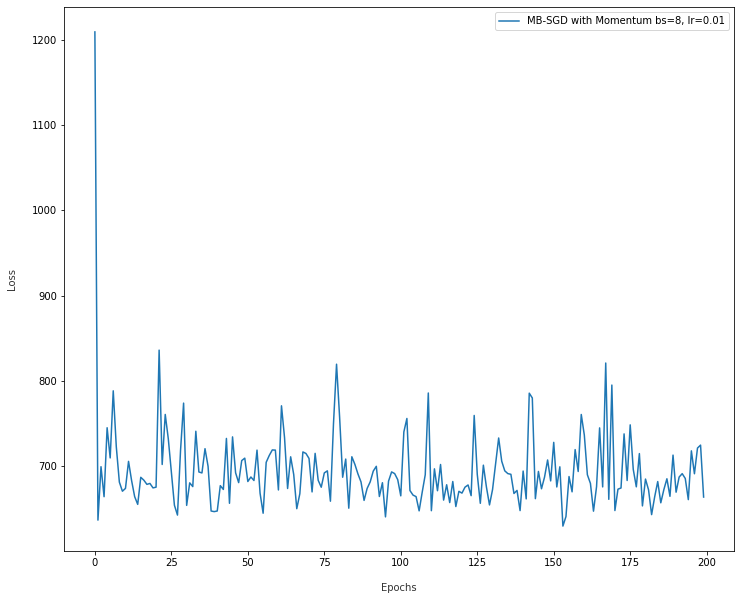

In [20]:
# MB-SGD with Momentum
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_mbsgdm = Model(n_features, 100, 50)
optimizer = optim.SGD(net_mbsgdm.parameters(),momentum=0.9, lr=0.01) 
# Setting the mini batch size to 8
all_losses_mbsgdm,t_mbsgdm,l_mbsgdm = train_model(8, 200,train_set,criterion,optimizer,net_mbsgdm)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_mbsgdm)), all_losses_mbsgdm, label = 'MB-SGD with Momentum bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #0	Loss: 4013.492


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #1	Loss: 3351.591


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #2	Loss: 2822.753


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #3	Loss: 2385.058


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #4	Loss: 2018.198


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #5	Loss: 1716.463


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #6	Loss: 1472.328


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #7	Loss: 1280.483


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #8	Loss: 1132.863


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #9	Loss: 1020.912


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #10	Loss: 936.401


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #11	Loss: 872.165


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #12	Loss: 823.079


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #13	Loss: 785.673


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #14	Loss: 756.749


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #15	Loss: 733.878


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #16	Loss: 715.359


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #17	Loss: 700.099


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #18	Loss: 686.988


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #19	Loss: 675.743


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #20	Loss: 665.646


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #21	Loss: 656.539


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #22	Loss: 647.967


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #23	Loss: 640.162


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #24	Loss: 632.913


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #25	Loss: 625.946


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #26	Loss: 619.255


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #27	Loss: 612.920


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #28	Loss: 606.939


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #29	Loss: 601.057


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #30	Loss: 595.460


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #31	Loss: 589.912


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #32	Loss: 584.625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #33	Loss: 579.530


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #34	Loss: 574.521


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #35	Loss: 569.700


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #36	Loss: 564.909


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #37	Loss: 560.261


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #38	Loss: 555.777


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #39	Loss: 551.385


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #40	Loss: 547.031


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #41	Loss: 542.854


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #42	Loss: 538.743


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #43	Loss: 534.747


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #44	Loss: 530.793


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #45	Loss: 526.964


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #46	Loss: 523.066


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #47	Loss: 519.279


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #48	Loss: 515.680


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #49	Loss: 512.107


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #50	Loss: 508.504


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #51	Loss: 505.001


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #52	Loss: 501.230


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #53	Loss: 497.663


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #54	Loss: 494.070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #55	Loss: 490.454


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #56	Loss: 486.921


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #57	Loss: 483.567


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #58	Loss: 480.085


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #59	Loss: 476.787


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #60	Loss: 473.402


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #61	Loss: 470.273


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #62	Loss: 466.986


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #63	Loss: 463.951


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #64	Loss: 460.851


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #65	Loss: 457.929


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #66	Loss: 454.788


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #67	Loss: 451.901


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #68	Loss: 449.054


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #69	Loss: 446.182


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #70	Loss: 443.442


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #71	Loss: 440.633


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #72	Loss: 437.914


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #73	Loss: 435.271


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #74	Loss: 432.640


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #75	Loss: 430.038


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #76	Loss: 427.482


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #77	Loss: 424.983


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #78	Loss: 422.547


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #79	Loss: 420.082


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #80	Loss: 417.662


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #81	Loss: 415.266


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #82	Loss: 412.997


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #83	Loss: 410.692


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #84	Loss: 408.367


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #85	Loss: 406.110


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #86	Loss: 403.922


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #87	Loss: 401.729


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #88	Loss: 399.552


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #89	Loss: 397.465


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #90	Loss: 395.386


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #91	Loss: 393.280


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #92	Loss: 391.217


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #93	Loss: 389.250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #94	Loss: 387.274


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #95	Loss: 385.332


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #96	Loss: 383.424


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #97	Loss: 381.482


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #98	Loss: 379.597


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #99	Loss: 377.750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #100	Loss: 375.877


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #101	Loss: 374.101


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #102	Loss: 372.312


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #103	Loss: 370.539


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #104	Loss: 368.811


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #105	Loss: 367.133


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #106	Loss: 365.390


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #107	Loss: 363.683


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #108	Loss: 362.035


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #109	Loss: 360.387


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #110	Loss: 358.775


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #111	Loss: 357.210


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #112	Loss: 355.593


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #113	Loss: 354.018


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #114	Loss: 352.506


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #115	Loss: 350.991


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #116	Loss: 349.482


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #117	Loss: 348.013


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #118	Loss: 346.572


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #119	Loss: 345.099


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #120	Loss: 343.666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #121	Loss: 342.243


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #122	Loss: 340.838


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #123	Loss: 339.448


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #124	Loss: 338.103


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #125	Loss: 336.738


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #126	Loss: 335.399


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #127	Loss: 334.074


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #128	Loss: 332.820


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #129	Loss: 331.525


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #130	Loss: 330.266


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #131	Loss: 328.987


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #132	Loss: 327.798


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #133	Loss: 326.531


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #134	Loss: 325.327


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #135	Loss: 324.129


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #136	Loss: 322.958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #137	Loss: 321.816


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #138	Loss: 320.624


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #139	Loss: 319.524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #140	Loss: 318.360


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #141	Loss: 317.261


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #142	Loss: 316.203


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #143	Loss: 315.080


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #144	Loss: 314.006


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #145	Loss: 312.969


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #146	Loss: 311.926


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #147	Loss: 310.891


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #148	Loss: 309.856


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #149	Loss: 308.829


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #150	Loss: 307.885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #151	Loss: 306.818


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #152	Loss: 305.913


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #153	Loss: 304.905


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #154	Loss: 303.964


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #155	Loss: 303.042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #156	Loss: 302.146


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #157	Loss: 301.198


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #158	Loss: 300.306


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #159	Loss: 299.352


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #160	Loss: 298.487


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #161	Loss: 297.586


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #162	Loss: 296.751


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #163	Loss: 295.867


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #164	Loss: 295.021


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #165	Loss: 294.182


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #166	Loss: 293.390


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #167	Loss: 292.587


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #168	Loss: 291.726


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #169	Loss: 290.977


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #170	Loss: 290.144


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #171	Loss: 289.358


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #172	Loss: 288.609


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #173	Loss: 287.815


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #174	Loss: 287.068


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #175	Loss: 286.367


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #176	Loss: 285.613


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #177	Loss: 284.851


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #178	Loss: 284.132


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #179	Loss: 283.428


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #180	Loss: 282.708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #181	Loss: 282.010


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #182	Loss: 281.311


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #183	Loss: 280.661


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #184	Loss: 280.005


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #185	Loss: 279.301


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #186	Loss: 278.665


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #187	Loss: 278.023


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #188	Loss: 277.357


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #189	Loss: 276.709


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #190	Loss: 276.084


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #191	Loss: 275.473


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #192	Loss: 274.865


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #193	Loss: 274.252


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #194	Loss: 273.619


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #195	Loss: 273.067


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #196	Loss: 272.411


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #197	Loss: 271.814


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #198	Loss: 271.282


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #199	Loss: 270.677
Time taken:18.421920776367188 seconds. 


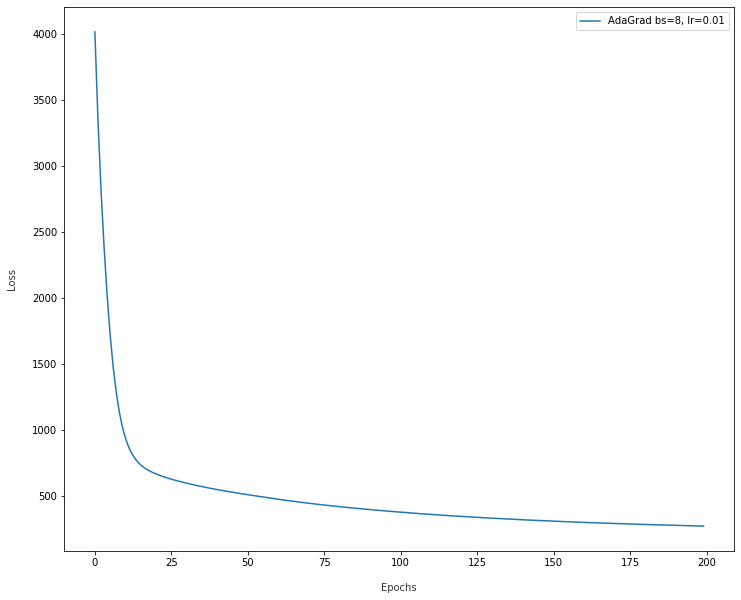

In [21]:
# AdaGrad
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_AdaGrad = Model(n_features, 100, 50)
optimizer = optim.Adagrad(net_AdaGrad.parameters(), lr=0.01) 
# Setting the mini batch size to 8
all_losses_adagrad,t_adagrad,l_adagrad = train_model(8, 200,train_set,criterion,optimizer,net_AdaGrad)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_adagrad)), all_losses_adagrad, label = 'AdaGrad bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #0	Loss: 1029.251


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #1	Loss: 365.725


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #2	Loss: 271.608


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #3	Loss: 238.456


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #4	Loss: 230.347


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #5	Loss: 226.144


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #6	Loss: 219.768


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #7	Loss: 213.253


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #8	Loss: 216.158


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #9	Loss: 213.460


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #10	Loss: 206.899


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #11	Loss: 208.841


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #12	Loss: 198.429


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #13	Loss: 200.001


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #14	Loss: 199.841


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #15	Loss: 197.269


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #16	Loss: 194.754


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #17	Loss: 195.885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #18	Loss: 191.119


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #19	Loss: 192.261


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #20	Loss: 189.859


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #21	Loss: 184.872


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #22	Loss: 184.779


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #23	Loss: 188.575


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #24	Loss: 186.435


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #25	Loss: 177.702


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #26	Loss: 181.603


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #27	Loss: 176.919


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #28	Loss: 187.344


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #29	Loss: 180.191


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #30	Loss: 177.478


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #31	Loss: 176.475


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #32	Loss: 173.210


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #33	Loss: 175.181


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #34	Loss: 177.317


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #35	Loss: 174.692


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #36	Loss: 173.449


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #37	Loss: 169.476


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #38	Loss: 174.374


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #39	Loss: 172.430


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #40	Loss: 170.827


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #41	Loss: 171.659


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #42	Loss: 176.132


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #43	Loss: 172.966


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #44	Loss: 174.207


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #45	Loss: 173.710


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #46	Loss: 173.261


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #47	Loss: 174.255


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #48	Loss: 167.757


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #49	Loss: 175.944


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #50	Loss: 175.411


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #51	Loss: 166.475


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #52	Loss: 169.362


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #53	Loss: 171.292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #54	Loss: 168.394


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #55	Loss: 170.046


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #56	Loss: 170.640


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #57	Loss: 171.593


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #58	Loss: 169.466


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #59	Loss: 171.005


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #60	Loss: 168.317


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #61	Loss: 175.079


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #62	Loss: 168.592


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #63	Loss: 163.885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #64	Loss: 171.390


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #65	Loss: 171.516


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #66	Loss: 166.530


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #67	Loss: 170.503


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #68	Loss: 168.174


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #69	Loss: 165.819


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #70	Loss: 168.340


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #71	Loss: 171.023


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #72	Loss: 165.122


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #73	Loss: 170.994


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #74	Loss: 169.894


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #75	Loss: 167.682


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #76	Loss: 167.045


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #77	Loss: 167.129


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #78	Loss: 168.226


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #79	Loss: 171.681


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #80	Loss: 171.179


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #81	Loss: 171.749


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #82	Loss: 170.713


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #83	Loss: 168.700


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #84	Loss: 166.804


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #85	Loss: 166.277


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #86	Loss: 168.025


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #87	Loss: 166.416


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #88	Loss: 164.397


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #89	Loss: 168.017


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #90	Loss: 168.482


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #91	Loss: 164.748


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #92	Loss: 167.060


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #93	Loss: 170.441


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #94	Loss: 166.853


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #95	Loss: 166.687


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #96	Loss: 168.943


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #97	Loss: 167.011


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #98	Loss: 166.998


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #99	Loss: 165.684


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #100	Loss: 162.985


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #101	Loss: 170.530


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #102	Loss: 167.603


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #103	Loss: 168.643


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #104	Loss: 168.126


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #105	Loss: 167.274


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #106	Loss: 167.502


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #107	Loss: 168.135


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #108	Loss: 168.262


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #109	Loss: 165.288


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #110	Loss: 163.019


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #111	Loss: 166.633


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #112	Loss: 167.325


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #113	Loss: 162.748


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #114	Loss: 161.127


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #115	Loss: 162.963


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #116	Loss: 167.776


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #117	Loss: 165.880


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #118	Loss: 170.107


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #119	Loss: 166.531


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #120	Loss: 166.940


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #121	Loss: 165.260


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #122	Loss: 167.893


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #123	Loss: 167.190


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #124	Loss: 163.975


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #125	Loss: 165.590


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #126	Loss: 164.831


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #127	Loss: 163.972


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #128	Loss: 165.823


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #129	Loss: 164.888


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #130	Loss: 163.054


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #131	Loss: 167.205


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #132	Loss: 162.939


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #133	Loss: 166.372


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #134	Loss: 164.060


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #135	Loss: 163.989


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #136	Loss: 163.670


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #137	Loss: 159.903


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #138	Loss: 164.985


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #139	Loss: 166.015


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #140	Loss: 160.054


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #141	Loss: 166.939


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #142	Loss: 161.718


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #143	Loss: 164.421


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #144	Loss: 162.508


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #145	Loss: 163.102


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #146	Loss: 163.766


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #147	Loss: 165.040


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #148	Loss: 165.844


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #149	Loss: 162.828


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #150	Loss: 165.961


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #151	Loss: 161.070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #152	Loss: 161.496


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #153	Loss: 166.471


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #154	Loss: 163.986


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #155	Loss: 161.549


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #156	Loss: 166.504


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #157	Loss: 162.404


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #158	Loss: 163.881


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #159	Loss: 161.060


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #160	Loss: 159.949


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #161	Loss: 161.119


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #162	Loss: 166.292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #163	Loss: 163.300


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #164	Loss: 160.981


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #165	Loss: 161.540


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #166	Loss: 163.121


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #167	Loss: 168.013


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #168	Loss: 162.367


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #169	Loss: 159.983


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #170	Loss: 163.883


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #171	Loss: 162.929


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #172	Loss: 164.283


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #173	Loss: 159.914


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #174	Loss: 161.947


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #175	Loss: 158.202


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #176	Loss: 164.457


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #177	Loss: 161.409


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #178	Loss: 160.990


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #179	Loss: 163.712


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #180	Loss: 160.013


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #181	Loss: 163.619


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #182	Loss: 159.569


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #183	Loss: 162.659


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #184	Loss: 158.282


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #185	Loss: 161.710


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #186	Loss: 161.503


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #187	Loss: 163.479


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #188	Loss: 161.175


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #189	Loss: 161.794


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #190	Loss: 161.713


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #191	Loss: 161.736


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #192	Loss: 164.170


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #193	Loss: 162.442


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #194	Loss: 163.245


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #195	Loss: 166.961


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #196	Loss: 160.636


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #197	Loss: 158.580


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #198	Loss: 159.991


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #199	Loss: 160.842
Time taken:19.449801445007324 seconds. 


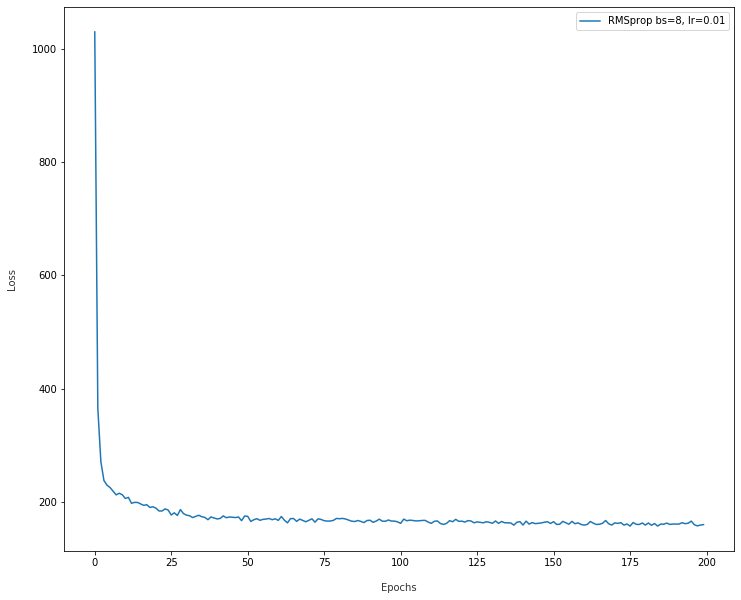

In [22]:
# RMSprop
torch.manual_seed(1)
criterion = nn.MSELoss(size_average=False)
net_rms = Model(n_features, 100, 50)
optimizer = optim.RMSprop(net_rms.parameters(), lr=0.01) 
# Setting the mini batch size to 8
all_losses_rms,t_rms,l_rms = train_model(8, 200,train_set,criterion,optimizer,net_rms)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_rms)), all_losses_rms, label = 'RMSprop bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #0	Loss: 3128.956


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #1	Loss: 774.545


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #2	Loss: 541.205


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #3	Loss: 407.852


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #4	Loss: 314.213


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #5	Loss: 264.724


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #6	Loss: 239.115


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #7	Loss: 225.978


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #8	Loss: 213.651


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #9	Loss: 208.848


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #10	Loss: 203.337


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #11	Loss: 199.969


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #12	Loss: 194.199


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #13	Loss: 193.990


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #14	Loss: 191.415


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #15	Loss: 189.285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #16	Loss: 185.110


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #17	Loss: 189.502


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #18	Loss: 182.167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #19	Loss: 186.210


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #20	Loss: 179.066


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #21	Loss: 182.679


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #22	Loss: 179.460


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #23	Loss: 175.070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #24	Loss: 175.717


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #25	Loss: 177.707


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #26	Loss: 176.443


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #27	Loss: 180.004


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #28	Loss: 175.739


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #29	Loss: 173.873


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #30	Loss: 172.310


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #31	Loss: 172.597


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #32	Loss: 171.848


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #33	Loss: 172.798


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #34	Loss: 168.646


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #35	Loss: 171.960


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #36	Loss: 170.345


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #37	Loss: 172.317


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #38	Loss: 171.781


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #39	Loss: 176.293


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #40	Loss: 176.058


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #41	Loss: 168.607


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #42	Loss: 181.377


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #43	Loss: 173.350


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #44	Loss: 166.920


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #45	Loss: 167.196


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #46	Loss: 171.057


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #47	Loss: 167.968


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #48	Loss: 168.773


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #49	Loss: 169.644


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #50	Loss: 173.620


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #51	Loss: 168.608


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #52	Loss: 166.360


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #53	Loss: 171.150


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #54	Loss: 169.704


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #55	Loss: 169.776


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #56	Loss: 167.173


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #57	Loss: 171.434


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #58	Loss: 173.987


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #59	Loss: 165.563


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #60	Loss: 167.027


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #61	Loss: 169.706


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #62	Loss: 167.181


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #63	Loss: 169.193


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #64	Loss: 164.762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #65	Loss: 169.055


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #66	Loss: 171.536


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #67	Loss: 169.750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #68	Loss: 167.733


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #69	Loss: 167.834


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #70	Loss: 167.622


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #71	Loss: 167.137


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #72	Loss: 168.373


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #73	Loss: 165.666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #74	Loss: 167.096


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #75	Loss: 167.564


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #76	Loss: 167.184


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #77	Loss: 166.666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #78	Loss: 165.977


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #79	Loss: 165.728


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #80	Loss: 167.797


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #81	Loss: 165.717


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #82	Loss: 164.884


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #83	Loss: 165.236


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #84	Loss: 167.761


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #85	Loss: 172.477


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #86	Loss: 170.205


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #87	Loss: 166.518


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #88	Loss: 164.722


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #89	Loss: 170.308


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #90	Loss: 166.832


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #91	Loss: 163.171


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #92	Loss: 165.569


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #93	Loss: 166.116


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #94	Loss: 164.036


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #95	Loss: 168.677


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #96	Loss: 165.343


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #97	Loss: 165.878


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #98	Loss: 173.584


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #99	Loss: 168.114


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #100	Loss: 169.715


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #101	Loss: 168.003


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #102	Loss: 164.731


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #103	Loss: 164.164


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #104	Loss: 170.457


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #105	Loss: 166.320


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #106	Loss: 170.582


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #107	Loss: 171.388


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #108	Loss: 168.916


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #109	Loss: 168.814


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #110	Loss: 168.244


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #111	Loss: 166.643


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #112	Loss: 172.757


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #113	Loss: 169.762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #114	Loss: 170.877


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #115	Loss: 167.607


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #116	Loss: 170.051


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #117	Loss: 172.444


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #118	Loss: 165.700


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #119	Loss: 165.084


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #120	Loss: 169.308


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #121	Loss: 165.532


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #122	Loss: 164.690


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #123	Loss: 168.708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #124	Loss: 172.597


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #125	Loss: 164.712


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #126	Loss: 165.808


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #127	Loss: 163.988


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #128	Loss: 165.826


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #129	Loss: 163.901


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #130	Loss: 168.004


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #131	Loss: 172.473


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #132	Loss: 165.494


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #133	Loss: 170.298


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #134	Loss: 174.365


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #135	Loss: 163.306


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #136	Loss: 164.505


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #137	Loss: 165.281


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #138	Loss: 175.692


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #139	Loss: 166.677


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #140	Loss: 167.187


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #141	Loss: 165.237


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #142	Loss: 163.383


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #143	Loss: 164.360


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #144	Loss: 173.126


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #145	Loss: 171.427


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #146	Loss: 165.306


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #147	Loss: 170.793


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #148	Loss: 166.303


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #149	Loss: 167.389


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #150	Loss: 163.735


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #151	Loss: 166.862


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #152	Loss: 165.210


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #153	Loss: 166.225


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #154	Loss: 166.510


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #155	Loss: 168.091


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #156	Loss: 167.805


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #157	Loss: 175.092


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #158	Loss: 168.141


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #159	Loss: 165.377


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #160	Loss: 166.893


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #161	Loss: 168.164


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #162	Loss: 166.871


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #163	Loss: 165.622


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #164	Loss: 163.355


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #165	Loss: 165.335


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #166	Loss: 164.867


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #167	Loss: 163.607


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #168	Loss: 169.420


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #169	Loss: 164.067


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #170	Loss: 165.325


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #171	Loss: 166.416


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #172	Loss: 169.221


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #173	Loss: 165.316


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #174	Loss: 161.506


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #175	Loss: 169.744


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #176	Loss: 166.034


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #177	Loss: 164.781


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #178	Loss: 162.497


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #179	Loss: 166.219


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #180	Loss: 165.877


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #181	Loss: 164.930


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #182	Loss: 164.669


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #183	Loss: 164.552


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #184	Loss: 167.290


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #185	Loss: 166.249


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #186	Loss: 164.947


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #187	Loss: 164.349


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #188	Loss: 165.818


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #189	Loss: 164.952


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #190	Loss: 164.921


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #191	Loss: 167.232


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #192	Loss: 165.917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #193	Loss: 161.264


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #194	Loss: 166.485


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #195	Loss: 164.069


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #196	Loss: 163.552


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #197	Loss: 167.427


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #198	Loss: 164.366


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch #199	Loss: 164.775
Time taken:20.070021629333496 seconds. 


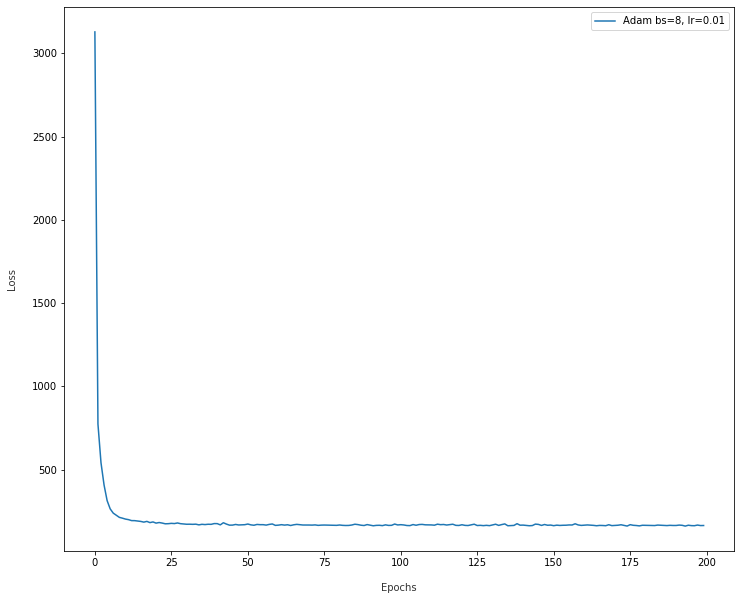

In [23]:
# Adam
torch.random.seed()
criterion = nn.MSELoss(size_average=False)
net_adam = Model(n_features, 100, 50)
optimizer = optim.Adam(net_adam.parameters(), lr=0.01) 
# Setting the mini batch size to 8
all_losses_adam,t_adam,l_adam = train_model(8, 200,train_set,criterion,optimizer,net_adam)

plt.figure(figsize=(12, 10))
plt.plot(range(len(all_losses_adam)), all_losses_adam, label = 'Adam bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

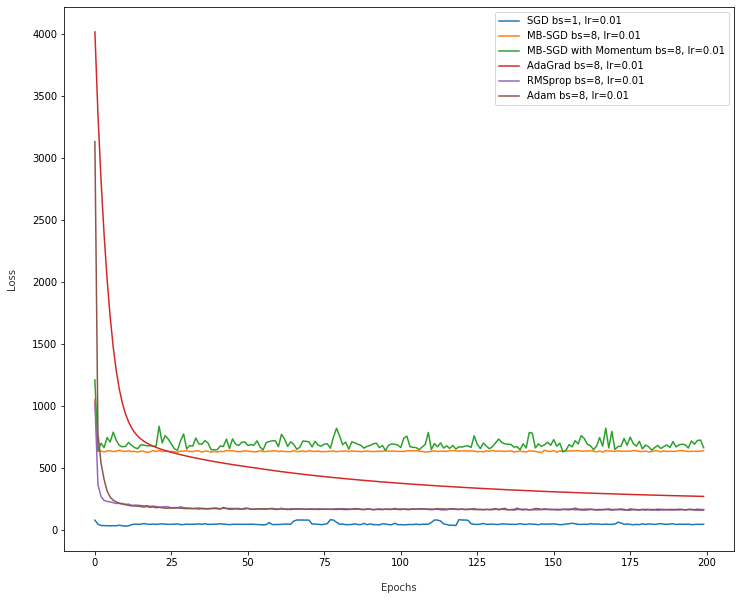

In [24]:
plt.figure(figsize=(12, 10))
# excluding the GD plot since it messes with the overall scale 
#plt.plot(range(len(all_losses_gd)), all_losses_gd, label = 'GD bs=num_samples, lr=0.001')
plt.plot(range(len(all_losses_sgd)), all_losses_sgd, label = 'SGD bs=1, lr=0.01')
plt.plot(range(len(all_losses_mbsgd)), all_losses_mbsgd, label = 'MB-SGD bs=8, lr=0.01')
plt.plot(range(len(all_losses_mbsgdm)), all_losses_mbsgdm, label = 'MB-SGD with Momentum bs=8, lr=0.01')
plt.plot(range(len(all_losses_adagrad)), all_losses_adagrad, label = 'AdaGrad bs=8, lr=0.01')
plt.plot(range(len(all_losses_rms)), all_losses_rms, label = 'RMSprop bs=8, lr=0.01')
plt.plot(range(len(all_losses_adam)), all_losses_adam, label = 'Adam bs=8, lr=0.01')
plt.legend(loc='upper right')
plt.xlabel('Epochs', labelpad=15, color='#333333')
plt.ylabel('Loss', labelpad=15, color='#333333')
plt.show()

In [25]:
time_list =[t_gd,t_sgd,t_mbsgd,t_mbsgdm,t_adagrad,t_rms,t_adam]
loss_list =[l_gd,l_sgd,l_mbsgd,l_mbsgdm,l_adagrad,l_rms,l_adam]
opt_list =['GD','SGD','MB-SGD','MB-SGD with Momentum','AdaGrad','RMSprop','Adam']

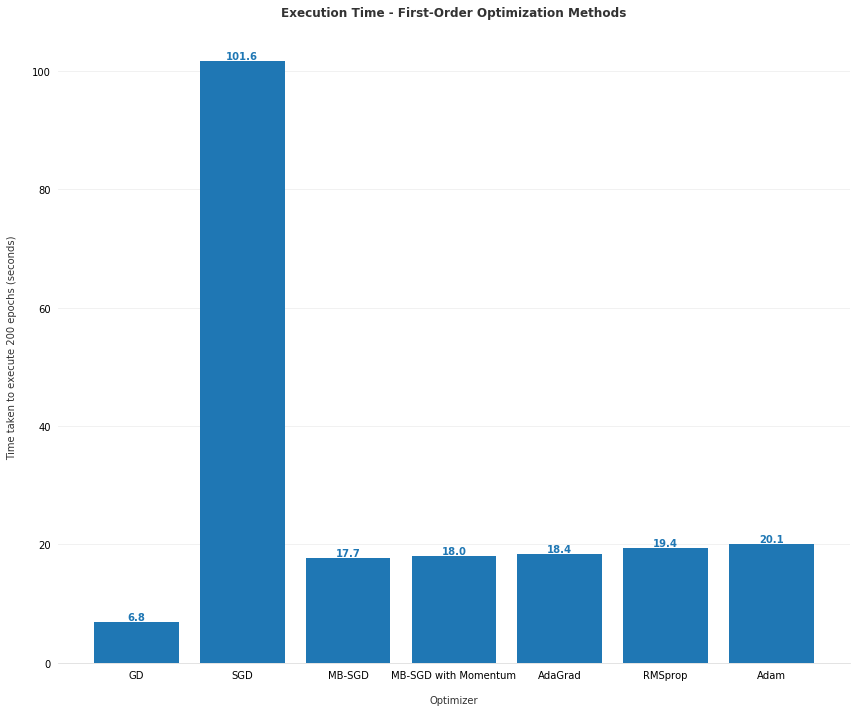

In [26]:
# formatting style derived from: https://www.pythoncharts.com/matplotlib/beautiful-bar-charts-matplotlib/
# compare execution time for all the optimization methods discussed

fig, ax = plt.subplots(figsize=(12, 10))

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=opt_list,
    height=time_list
    
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Optimizer', labelpad=15, color='#333333')
ax.set_ylabel('Time taken to execute 200 epochs (seconds)', labelpad=15, color='#333333')
ax.set_title('Execution Time - First-Order Optimization Methods', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

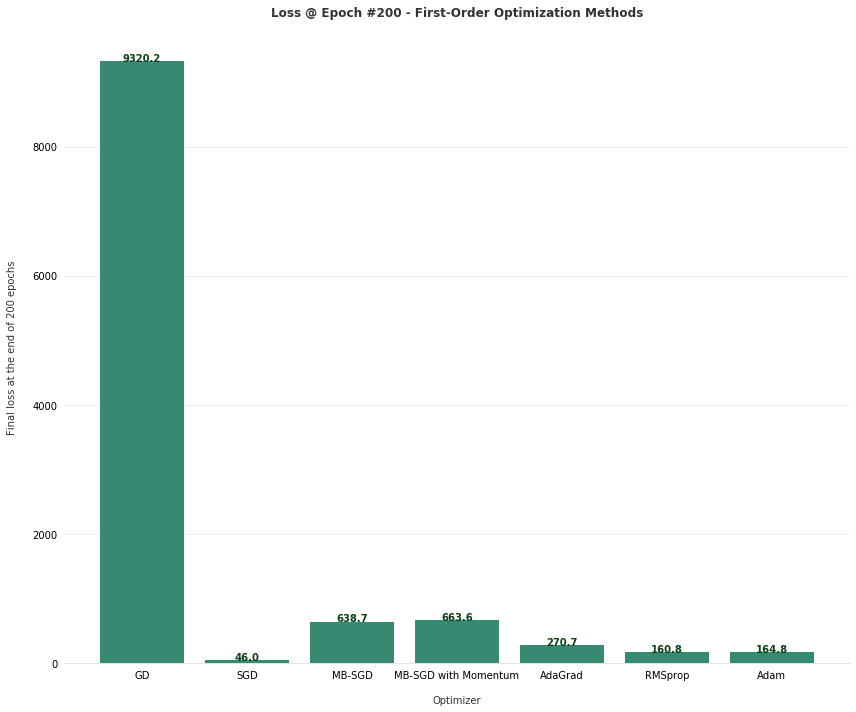

In [27]:
# formatting style derived from: https://www.pythoncharts.com/matplotlib/beautiful-bar-charts-matplotlib/
# compare the loss at epoch # 200 for all the optimization methods discussed

fig, ax = plt.subplots(figsize=(12, 10))

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=opt_list,
    height=loss_list,
    color='#378a72'
    
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = '#084214'
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Optimizer', labelpad=15, color='#333333')
ax.set_ylabel('Final loss at the end of 200 epochs', labelpad=15, color='#333333')
ax.set_title('Loss @ Epoch #200 - First-Order Optimization Methods', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()